# INFO371: Problem Set 4, due May 22 at 3:30pm.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of
  this problem set to make sure to do it well and understand what
  you've done. If you find your gradient descent algorithm is taking
  more than a few minutes to complete (it takes ~15s for me), debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 3.3 will be relatively painless or incredibly painful. 
* Part 3 and 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt  
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
# use cross_validation for earlier versions of sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

import time
from functools import reduce

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented

Learn the existing libraries for OLS and cross validation.

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset as we did for the
previous PS, use linear regression from sklearn or SciPy to explore
the relationship between  median housing price and number of rooms per
house.  Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  **Interpret your results.**

In [3]:
# your code
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names
boston['MEDV'] = bdata.target

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(boston['RM'].values, boston['MEDV'])
print(sp.stats.linregress(boston['RM'].values, boston['MEDV']))
print()

secondSet = [boston["RM"], boston["RM"] * boston["RM"]]
linReg = lm.LinearRegression()
x = np.array(secondSet).T
y = np.array(boston["MEDV"]).T
solution = linReg.fit(x,y)
betas = solution.coef_
intercept = solution.intercept_

print(betas)
print(intercept)

LinregressResult(slope=9.102108981180308, intercept=-34.670620776438554, rvalue=0.69535994707153936, pvalue=2.4872288710078101e-74, stderr=0.41902656012134021)

[-22.64326237   2.47012384]
66.0588474848


your interpretation...

### 1.2 Training and testing

Above, you probably used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the cross\_validation (or model\_selection) functions from
scikit-learn, use k-fold cross-validation to fit regression (a) above,
i.e. the linear fit of housing price on number of rooms per house.
Use a large $k$ value, say, 100.  Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the k slope coefficients, and draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you observe?

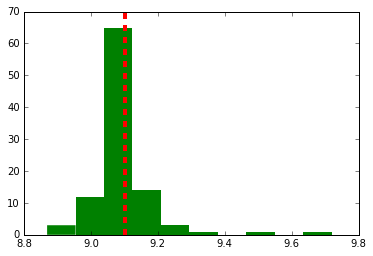

In [4]:
## code
kf = KFold(n_splits=100)
X = boston["RM"]
Y = boston["MEDV"]
kf.get_n_splits(X)

KCoefs = []
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    kFoldsLinReg = lm.LinearRegression()
    
    output = kFoldsLinReg.fit(np.matrix(X_train).T, np.matrix(y_train).T)
    #print('coefs',output.coef_)
    predictions = output.predict(np.matrix(X_test).T)
    KCoefs.append(output.coef_[0][0])

plt.axvline(slope, color = 'r', linestyle = 'dashed', linewidth = 4)
plt.hist(KCoefs, color = 'g', edgecolor = "none",)
plt.show()

what do you observe?

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the
two regression lines from 1.1 (or 1.2 if you prefer to do so). Show
the linear regression line in red, and the linear + quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

NameError: name 'X_first' is not defined

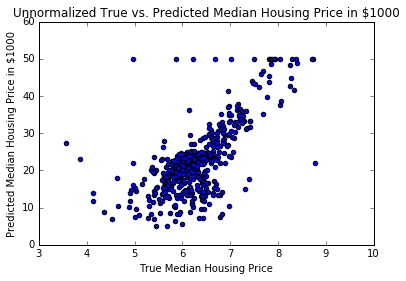

In [42]:
# code
p, ax = plt.subplots()
plt.scatter(X,Y)
plt.title("Unnormalized True vs. Predicted Median Housing Price in $1000")
plt.ylabel("Predicted Median Housing Price in $1000")
plt.xlabel("True Median Housing Price")

plt.plot(X, linReg.predict(X_first),color = 'r', linestyle = 'dashed', linewidth = 2)
plt.plot(X, linReg.predict(X_total),color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.scatter(X, Y, color = 'g', edgecolor = "none",)
plt.show()

## Part 2: Gradient descent: Linear Regression

Here we'll really get serious.  It's your turn to implement some
methods now.

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the basic gradient descent algorithm that we discussed in
class. Use the version you implement to regress the housing price on
the number of rooms per house. Experiment with 3-4 different values of
the learning rate $R$ to find the one that works well.  Comment your results.

Do the following:

* At each beta value compute the gradient of the loss function (Note:
  this is a vector of 2 components, bias and RM) and change beta in that direction.
* Repeat the process until convergence (or until you lose the hope you
  will ever get that far ;-)
* Report the values of the parameter that minimize the loss function
* For each value of $R$ Report the number of iterations it takes for
  your algorithm to converge (or not to explode)
* Report the total running time of your algorithm

Here you are supposed to code the algorithm for a single explanatory
variable (RM) and constant.  I strongly recommend you to do it in
matrix form but you can also loop over your data.  Note that if done
in matrix form, the function here is almost exactly the same as for
multple regression you are asked to implement later.

* Hint 1: Don't forget to implement stopping conditions, so that at
  every iteration you check whether your results have
  converged. Common approaches to this are to (a) check if the loss
  has stopped decreasing; (b) check if both your current parameter
  esimates are close to the estimates from the previous iteration; (c)
  check if your gradient is close to zero..  In both cases, "close"
  should not be == 0, it should be <=epsilon, where epsilon is a small
  number, such as 1e-6).
* Hint 2: include a maximum number of iterations to avoid the code
  running for ever.  Report "no convergence" if this is exceeded.
  Depending on your code, you may need 30,000 iterations.
* Hint 3: $R = 10^{-4}$ may be a good starting point.  But it depends
on how exactly do you write your loss function

Bonus challenge if you feel for it:
* Implement an adaptive version of learning rate.

In [64]:
"""
Function
--------
ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: n x 2, independent variables.  One column should be constant
    yvalues: n x 1, dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

Returns
-------
(beta, iterations, convergence)
beta: float vector, the parameter value 
iterations: integer, number of iterations
convergece: logical, did the model converge?
"""



#Adapted from http://ozzieliu.com/2016/02/09/gradient-descent-tutorial/
def ols(xvalues, yvalues, R=0.0001, MaxIterations=1000):
    ## set initial beta.  Beta=0 may be a good choice
    beta = np.asmatrix(np.zeros((2, 1)))
    iterations = 0
    convergence = False
    
    m = xvalues.size
    lossHistory = np.array([0.0] * MaxIterations)
    ## iterate many times
    while not convergence:
        ### calculate loss
        loss = calculateLoss(xvalues, yvalues, beta)
        lossHistory[iterations] = loss
    
        ### calculate gradient of loss
        gradient = (np.dot( xvalues.T, (  np.dot(   xvalues, beta   ) - yvalues  ) ) / m)
        
        ### calculate new_beta = beta - R*gradient
        beta = beta - R * gradient
        iterations = iterations + 1
        
        convergence = (np.all(abs(gradient) < 0.00001))
        ### did L change much?  Did beta change much?  Have you tried too
        ### many times?
        if (iterations == MaxIterations):
            return beta, iterations, convergence
        
        ### If converged:
        if(convergence):
            return beta, iterations, True
    return beta, iterations, convergence


def calculateLoss(X, y, beta):
    """
    cost_function(X, y, beta) computes the cost of using beta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(X)

    ## Calculate the cost with the given parameters
    J = np.sum(np.square( np.dot(  X, beta  ) - y )) / (2 * m)

    return J

XNew = np.column_stack((np.ones(506), X))
YNew = np.asmatrix(Y).T

# Test 1 and Time
start_time = time.time()
print(ols(XNew, YNew))
print("Total Run Time of RM on MEDV; R = Default; MaxIterations = Default: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()

# Test 2 and Time
start_time = time.time()
print(ols(XNew, YNew, 0.01,20000))
print("Total Run Time of RM on MEDV; R = 0.01; MaxIterations = 20000: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()


# Test 3 and Time
start_time = time.time()
print(ols(XNew, YNew, 0.05, 40000))
print("Total Run Time of RM on MEDV; R = 0.05; MaxIterations = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")

(matrix([[ 0.46699831],
        [ 3.10864868]]), 1000, False)
Total Run Time of RM on MEDV; R = Default; MaxIterations = Default: 0.23 seconds.

(matrix([[-24.08470445],
        [  7.43794927]]), 20000, False)
Total Run Time of RM on MEDV; R = 0.01; MaxIterations = 20000: 2.82 seconds.

(matrix([[-34.66895811],
        [  9.1018476 ]]), 33134, True)
Total Run Time of RM on MEDV; R = 0.05; MaxIterations = 40000: 4.4 seconds.


Comment your results

### 2.2 Data normalization

Soon, you will implement a version of gradient descent that can use an
arbitrary number of independent variables. Before doing this, however,
you should re-scale your features to ensure that no single feature
dominates the cost function. Write a simple function to standardize
your features.  Below is my version, but you can also use what you did
in PS3.

In [8]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

def de_standardize(data):
    return data*np.std(data, axis = 0) + np.mean(data, axis = 0)

def normalize(toNormalize):
    mu = np.mean(toNormalize)
    sigma = np.std(toNormalize)
    return np.array([((x - mu) / sigma) for x in toNormalize])

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create
a version of gradient descent that can take more than one independent
variable.  Assume all independent variables will be continuous.  Test
your algorithm using CRIM and RM as independent variables. Standardize
these variables before before inputting them to the gradient descent
algorithm.   If you used a pure matrix approach above, you can copy
your previous algorithm almost verbatim.

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it
   might take a long time for your code to run.  Avoid looping over
   matrix rows and columns if you can and use canned matrix
   multiplication/other np functions like `np.mean`.  See the
   normalization example above.

In [63]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""


def multiple_ols(xvalue_matrix, y, independentVariablesCount, R=0.01, MaxIterations=1000):
    ## the algorithm is essentially the same as above
    ## set initial beta.  Beta=0 may be a good choice
    beta = np.asmatrix(np.zeros((independentVariablesCount, 1)))
    iterations = 0
    convergence = False
    
    m = xvalue_matrix.size
    lossHistory = np.array([0.0] * MaxIterations)
    ## iterate many times
    while not convergence:
        ### calculate loss
        loss = calculateLoss(xvalue_matrix, y, beta)
        lossHistory[iterations] = loss
    
        ### calculate gradient of loss
        gradient = (np.dot( xvalue_matrix.T, (  np.dot(   xvalue_matrix, beta   ) - y  ) ) / m)
        
        ### calculate new_beta = beta - R*gradient
        beta = beta - R * gradient
        iterations = iterations + 1
        
        convergence = (np.all(abs(gradient) < 0.00001))
        ### did L change much?  Did beta change much?  Have you tried too
        ### many times?
        if (iterations == MaxIterations):
            return np.array(beta), iterations, convergence
        
        ### If converged:
        if(convergence):
            return np.array(beta), iterations, True
    return np.array(beta), iterations, convergence


def calculateLoss(X, y, beta):
    """
    cost_function(X, y, beta) computes the cost of using beta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(X)

    ## Calculate the cost with the given parameters
    
    J = np.sum(np.square( np.dot(  X, beta  ) - y )) / (2 * m)

    return J


XMulti = np.column_stack((np.ones(506), standardize(X), standardize(boston["CRIM"])))
YMulti = np.asmatrix(standardize(Y)).T

indepVarCount = XMulti[0].size

# Test 1 and Time
start_time = time.time()
print(multiple_ols(XMulti, YMulti, indepVarCount))
print("Total Run Time of RM and CRIM on MEDV; R = Default; MaxIterations = Default: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()

# Test 2 and Time
start_time = time.time()
print(multiple_ols(XMulti, YMulti, indepVarCount, 0.001, 20000))
print("Total Run Time of RM and CRIM on MEDV; R = 0.01; MaxIterations = 20000: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()


# Test 3 and Time
start_time = time.time()
print(multiple_ols(XMulti, YMulti, indepVarCount, 0.0001, 40000))
print("Total Run Time of RM and CRIM on MEDV; R = 0.0001; MaxIterations = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()

# Test 4 and Time
start_time = time.time()
print(multiple_ols(XMulti, YMulti, indepVarCount, 0.05, 40000))
print("Total Run Time of RM and CRIM on MEDV; R = 0.05; MaxIterations = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")

(array([[  3.52430718e-15],
       [  6.19318652e-01],
       [ -2.51884444e-01]]), 1000, False)
Total Run Time of RM and CRIM on MEDV; R = Default; MaxIterations = Default: 0.14 seconds.

(array([[  4.43486369e-15],
       [  6.40310186e-01],
       [ -2.45696333e-01]]), 20000, False)
Total Run Time of RM and CRIM on MEDV; R = 0.01; MaxIterations = 20000: 3.17 seconds.

(array([[  8.38320556e-16],
       [  4.84297613e-01],
       [ -2.27734972e-01]]), 40000, False)
Total Run Time of RM and CRIM on MEDV; R = 0.0001; MaxIterations = 40000: 5.52 seconds.

(array([[  4.50728607e-15],
       [  6.41496209e-01],
       [ -2.44768962e-01]]), 657, True)
Total Run Time of RM and CRIM on MEDV; R = 0.05; MaxIterations = 40000: 0.09 seconds.


Your observations

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [ ]:
XMultiNonstandardized = np.column_stack((np.ones(506), X, boston["CRIM"]))
YMultiNonstandardized = np.asmatrix(Y).T

indepVarCount = XMultiNonstandardized[0].size

# Test 1 and Time
start_time = time.time()
print(multiple_ols(XMultiNonstandardized, YMultiNonstandardized, indepVarCount))
print("Total Run Time of NONSTANDARDIZED RM and CRIM on MEDV; R = Default; MaxIterations = Default: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()

# Test 2 and Time
start_time = time.time()
print(multiple_ols(XMultiNonstandardized, YMultiNonstandardized, indepVarCount, 0.001, 20000))
print("Total Run Time of NONSTANDARDIZED RM and CRIM on MEDV; R = 0.01; MaxIterations = 20000: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()


# Test 3 and Time
start_time = time.time()
print(multiple_ols(XMultiNonstandardized, YMultiNonstandardized, indepVarCount, 0.0001, 40000))
print("Total Run Time of NONSTANDARDIZED RM and CRIM on MEDV; R = 0.0001; MaxIterations = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")
print()

# Test 4 and Time
start_time = time.time()
print(multiple_ols(XMultiNonstandardized, YMultiNonstandardized, indepVarCount, 0.05, 40000))
print("Total Run Time of NONSTANDARDIZED RM and CRIM on MEDV; R = 0.05; MaxIterations = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")

(array([[-0.51333217],
       [ 3.92308633],
       [-0.35798312]]), 1000, False)
Total Run Time of NONSTANDARDIZED RM and CRIM on MEDV; R = Default; MaxIterations = Default: 0.17 seconds.



What do you see?

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, make sure to use the standardized version of your features in everything that follows.

### 3.1 Predicted values and RMSE

Let's figure out how accurate this predictive model turns out to
be. Report the average 10-fold cross-validated RMSE, separately for
the training data and for the testing data.  Feel freee to use 'sklearn's canned cross validation.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [11]:
def compute_rmse(inputList):
        squares = [x ** 2 for x in inputList]
        return np.sqrt(reduce(lambda x, y: x + y, squares) / len(squares))

In [58]:
# Your code here
tenkf = KFold(n_splits=10)


RMSEs = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(XMulti):
    X_train, X_test = XMulti[train_index], XMulti[test_index]
    y_train, y_test = YMulti[train_index], YMulti[test_index]
    
    myModel = np.asarray(multiple_ols(X_train, y_train, X_train[0].size, 0.05, 40000))
    coefs = np.matrix([myModel[0][i][0] for i in range(0,3)]).T
    predictions = np.dot(X_test, coefs)
    anRMSE = compute_rmse(y_test - predictions)
    
    RMSEs.append(anRMSE)
#     rmses1.append(rmse1)
print(np.mean(RMSEs))

0.62828008855


comment

### Extra Credit: Logistic Regression

For extra credit, implement logistic regression using gradient
descent. Create a new variable (EXPENSIVE) to indicate whether the
median housing price is more than $40,000. Estimate a logistic
regression model of EXPENSIVE on CHAS and RM.  Compute accuracy and recall.

In [13]:
# code


How well did it work?

## 4 Regularization 

### 4.1 Get prepped

Step 1: For each of the continuous features F in the original dataset, create a standardized version F_1.  Now, create polynomials up to degree 6 of each F_1: the square of F_1 (call this F_2); the cube of F_1 (call this F_3); and so forth up to F_6. If you originally had *K* features, you should now have *6K* features (i.e., we're going to ignore the original unscaled features for the remainder of this problem).

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [14]:
# EVERYTHING BUT CHAS
FList = list(bdata.feature_names)
FList.remove('CHAS')

FDimDictionary = {}

for feature in FList:
    for i in range(1, 7):
        FDimDictionary["" + feature + "_" + str(i)] = list(standardize(boston[feature]) ** i)

columnNames = sorted(FDimDictionary.keys())

values = []
for name in columnNames:
    values.append(FDimDictionary[name])
    
extraFs = pd.DataFrame(dict(zip(columnNames, values)))
    
seed = np.random.seed(seed=13579)
polyX_train, polyX_test, polyY_train, polyY_test = train_test_split(extraFs, Y, test_size=0.34, random_state=seed)

### 4.2 Let's overfit!
Now, using your version of multivariate regression from 2.3, (over)fit
your model on the training data. Using your training set, regress
housing price on as many of those *6K* features as you can.  If you
get too greedy, or if you did not efficiently implement your solution
to 2.3, it's possible this will take a long time to compute, or does
not converge at all.  

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 2.5 and nearest neighbors?

In [57]:
# code
OverFitX = np.column_stack((np.ones(len(polyX_train["CRIM_1"])), polyX_train["CRIM_1"], polyX_train["AGE_3"], polyX_train["ZN_2"], polyX_train["INDUS_4"], polyX_train["DIS_3"], polyX_train["NOX_1"], polyX_train["RAD_2"], polyX_train["PTRATIO_3"], polyX_train["RM_3"]))
polyY_train = np.asmatrix(polyY_train).T
indepVarCount = OverFitX[0].size

start_time = time.time()
print(multiple_ols(OverFitX, polyY_train, indepVarCount, 0.05, 40000))
print("Total Run Time of CRIM_1, AGE_3, ZN_2, INDUS_4, DIS_3, NOX_1, RAD_2, PTRATIO_3 and RM_3 on MEDV; R = 0.05; R = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")

myModel = np.asarray(multiple_ols(OverFitX, polyY_train, indepVarCount, 0.05, 40000))
coefs = np.matrix([myModel[0][i][0] for i in range(0,indepVarCount)]).T

print(polyX_test.shape)
print(coefs.shape)

# predictions = np.dot(polyX_test, coefs)
# anRMSE = compute_rmse(polyY_test - predictions)




(array([[ 21.05021701],
       [ -1.83437679],
       [ -0.22534915],
       [  0.33430524],
       [ -0.05521778],
       [ -0.44241847],
       [ -3.43723996],
       [  0.90357971],
       [ -0.87759068],
       [  0.4780555 ]]), 11169, True)
Total Run Time of CRIM_1, AGE_3, ZN_2, INDUS_4, DIS_3, NOX_1, RAD_2, PTRATIO_3 and RM_3 on MEDV; R = 0.05; R = 40000: 1.32 seconds.
(173, 72)
(10, 1)


Using our "overfit" regression, we see a drop in RMSE. As above, the actual values will depend on the random splits in the data, but in general we see that the RMSE is reduced by the largest margin on the training set, but the RMSE on the test set is still lower than the results from a regression with just two regressors

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols
regression.  You have to take your multiple regression code, and add
the penalization term to the gradient.  Add the penalty tuning parameter as an
additional argument to this function.  Remember not to penalize the
constant! 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Finally, go and brag to your friends about how you just implemented
ridge-regularized multivariate regression using gradient descent
optimization, from scratch. If you still have friends left ;-)

In [60]:
def multiple_regularized_ols(xvalue_matrix, y, independentVariablesCount, R=0.01, MaxIterations=1000, lbd=1):
    ## the only difference with multiple OLS: add the penalty
    ## parameter (both to loss and to gradient)
    W = np.eye(independentVariablesCount)
    W[0][0] = 0
    
    beta = np.asmatrix(np.zeros((independentVariablesCount, 1)))
    iterations = 0
    convergence = False
    
    m = xvalue_matrix.size
    lossHistory = np.array([0.0] * MaxIterations)
    
    ## iterate many times
    while not convergence:
        ### calculate loss
        pOfBeta = np.array(np.dot(beta.T, np.dot(W, beta)))[0][0]
        loss = (calculateLoss(xvalue_matrix, y, beta) + (lbd * pOfBeta))
        lossHistory[iterations] = loss
    
        ### calculate gradient of loss
        gradient = (( np.dot(  xvalue_matrix.T, (   np.dot(    xvalue_matrix, beta    ) - y   )  ) / m ) + (lbd * pOfBeta))
        
        ### calculate new_beta = beta - R*gradient
        beta = beta - R * gradient
        iterations = iterations + 1
        
        convergence = (np.all(abs(gradient) < 0.001))
        ### did L change much?  Did beta change much?  Have you tried too
        ### many times?
        if (iterations > 1 and lossHistory[iterations - 1] < loss):
            return beta, iterations, convergence
        
        if (iterations == MaxIterations):
            return beta, iterations, convergence
        
        ### If converged:
        if(convergence):
            return beta, iterations, True
    return alpha, beta_array, iterations, convergence


def calculateLoss(X, y, beta):
    """
    cost_function(X, y, beta) computes the cost of using beta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(X)

    ## Calculate the cost with the given parameters
    J = np.sum(np.square( np.dot(  X, beta  ) - y )) / (2 * m)
    return J

start_time = time.time()
print(multiple_regularized_ols(OverFitX, polyY_train, indepVarCount, 0.0000000005, 1202, 1300))
print("Total Run Time of RIDGE REGULARIZED CRIM_1, AGE_3, ZN_2, INDUS_4, DIS_3, NOX_1, RAD_2, PTRATIO_3 and RM_3 on MEDV; R = 0.05; R = 40000: " + str(round(time.time() - start_time, 2)) + " seconds.")

(matrix([[  1.38628822e-06],
        [ -2.22136989e-07],
        [ -1.02364955e-06],
        [  1.37589584e-06],
        [  2.21184474e-06],
        [  1.15009949e-06],
        [ -2.12254161e-07],
        [  1.13942271e-06],
        [ -1.88515255e-06],
        [  3.03056871e-06]]), 1202, False)
Total Run Time of RIDGE REGULARIZED CRIM_1, AGE_3, ZN_2, INDUS_4, DIS_3, NOX_1, RAD_2, PTRATIO_3 and RM_3 on MEDV; R = 0.05; R = 40000: 0.23 seconds.


what do you see?

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [17]:
# code

What is your optimal lambda?

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot.

In [18]:
# code

What do you see with coefficients and lambda?